# Project 22 - Image compression with convolutional autoencoders

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
dataset_train = datasets.MNIST('Datasets', train=True, download=True, transform=transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True)

In [3]:
dataset_val = datasets.MNIST('Datasets', train=False, download=True, transform=transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=256, shuffle=True)

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
        self.enc1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3), padding=(1,1))
        self.enc2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=(2,2), padding=(1,1))

        self.maxpool0 = nn.MaxPool2d(kernel_size=(2,2))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), padding=(1,1))

        self.flatten = nn.Flatten()

        self.dec0 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), padding=(1,1))
        self.dec1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), padding=(1,1))
        self.dec2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
        self.dec3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3,3), padding=(1,1))

        self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)

        self.activation0 = nn.ReLU()
        self.activation1 = nn.Sigmoid()

    def forward(self, X):
        X = self.maxpool0(self.activation0(self.enc0(X)))
        X = self.maxpool1(self.activation0(self.enc1(X)))
        X = self.flatten(self.activation0(self.enc2(X)))

        X = X.view(-1, 8, 4, 4)

        X = self.upsampling(self.activation0(self.dec0(X)))
        X = self.upsampling(self.activation0(self.dec1(X)))
        X = self.upsampling(self.activation0(self.dec2(X)))
        X = self.activation1(self.dec3(X))

        return X

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = autoencoder().to(device)

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
for epoch in range(5):

    running_loss_train = 0
    for data in loader_train:
        model.train()

        inputs, _ = data 
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()

        optimizer.step()

        running_loss_train += loss.item()

    running_loss_val = 0
    for data in loader_val:
        model.eval()

        inputs, _ = data 
        inputs = inputs.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))

        running_loss_val += loss.item()

    print(f'Epoch {epoch+1}/{20} - Loss Train: {running_loss_train/len(loader_train)} - Loss Val: {running_loss_val/len(loader_val)}')

Epoch 1/20 - Loss Train: 0.14083440221370536 - Loss Val: 0.138520098105073
Epoch 2/20 - Loss Train: 0.13838134674315758 - Loss Val: 0.13601251915097237
Epoch 3/20 - Loss Train: 0.13643845744589542 - Loss Val: 0.13460833504796027
Epoch 4/20 - Loss Train: 0.13449364976680026 - Loss Val: 0.13246064260601997
Epoch 5/20 - Loss Train: 0.13281952364647642 - Loss Val: 0.13095749765634537


In [9]:
for i, layer in enumerate(list(model.children())):
    print(i, layer)

0 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
1 Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
4 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
5 Flatten(start_dim=1, end_dim=-1)
6 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
9 Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
11 ReLU()
12 Sigmoid()


In [10]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc0 = list(model.children())[0]
        self.enc1 = list(model.children())[1]
        self.enc2 = list(model.children())[2]

        self.maxpool0 = list(model.children())[3]
        self.maxpool1 = list(model.children())[4]

        self.flatten = list(model.children())[5]

        self.activation0 = list(model.children())[11]

    def forward(self, X):
        X = self.maxpool0(self.activation0(self.enc0(X)))
        X = self.maxpool1(self.activation0(self.enc1(X)))
        X = self.flatten(self.activation0(self.enc2(X)))

        return X

In [11]:
model1 = encoder().to(device)

In [12]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.dec0 = list(model.children())[6]
        self.dec1 = list(model.children())[7]
        self.dec2 = list(model.children())[8]
        self.dec3 = list(model.children())[9]

        self.upsampling = list(model.children())[10]

        self.activation0 = list(model.children())[11]
        self.activation1 = list(model.children())[12]

    def forward(self, X):
        X = X.view(-1, 8, 4, 4)

        X = self.upsampling(self.activation0(self.dec0(X)))
        X = self.upsampling(self.activation0(self.dec1(X)))
        X = self.upsampling(self.activation0(self.dec2(X)))
        X = self.activation1(self.dec3(X))

        return X

In [13]:
model2 = decoder().to(device)

In [14]:
sample_size = 10

test_image = next(iter(loader_val))[0][:sample_size].to(device)

In [15]:
test_image.shape

torch.Size([10, 1, 28, 28])

In [16]:
model1.eval()
codify_image = model1(test_image)

In [17]:
codify_image.shape

torch.Size([10, 128])

In [18]:
model2.eval()
reconstructed_image = model2(codify_image)

In [19]:
reconstructed_image.shape

torch.Size([10, 1, 28, 28])

In [20]:
test_image = test_image.detach().cpu().numpy().reshape(-1, 28, 28)
codify_image = codify_image.detach().cpu().numpy().reshape(-1, 16,8)
reconstructed_image = reconstructed_image.detach().cpu().numpy().reshape(-1, 28, 28)

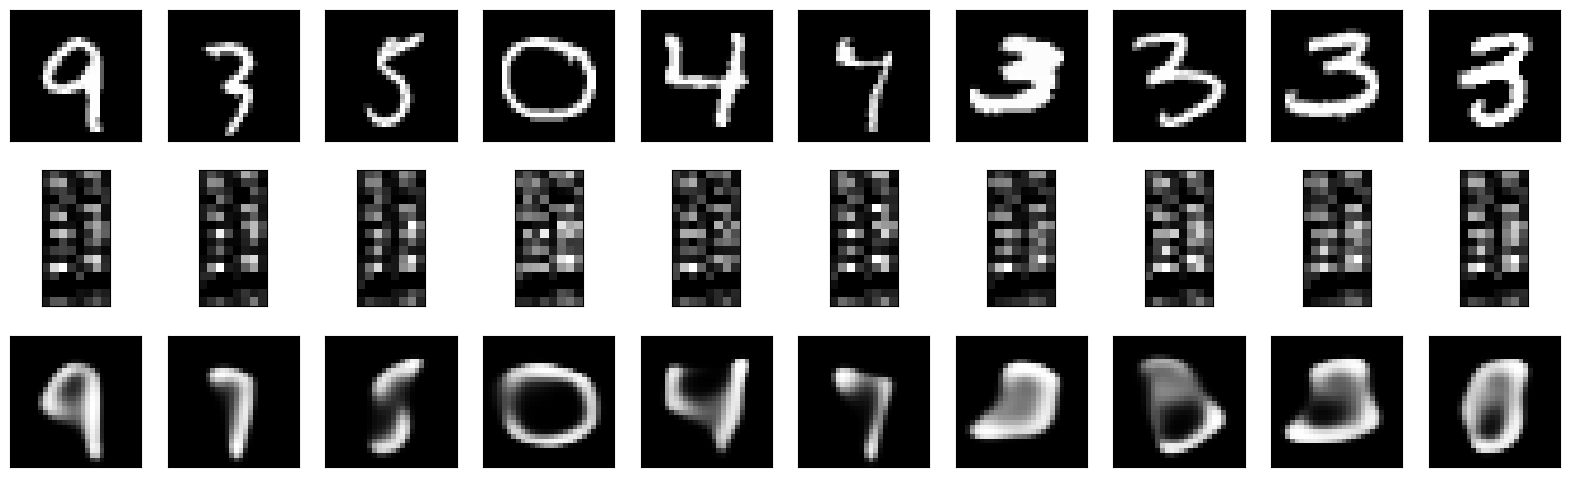

In [21]:
fig, axes = plt.subplots(nrows = 3, ncols=sample_size, figsize=(20, 6))

for imagens, ax_row in zip([test_image, codify_image, reconstructed_image], axes):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)